In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from peptdeep.pretrained_models import ModelManager

from alphabase.spectral_library.base import SpecLibBase
from alphadia import data, planning
from alphadia.workflow import manager, peptidecentric
from alphadia.tunning import settings, FinetuneManager


In [2]:
import torch
torch.set_num_threads(10)

In [4]:
transfer_lib = SpecLibBase()
transfer_lib.load_hdf('C:/Users/USER/Desktop/Germany/work/MPIB/alphaDia/second_pass_score/second_pass_score/output/speclib.transfer.hdf', load_mod_seq=True)

In [3]:
transfer_lib = SpecLibBase()
transfer_lib.load_hdf('C:/Users/USER/Desktop/Germany/work/MPIB/alphaDia/d0_search/output/speclib.transfer.hdf', load_mod_seq=True)

## RT Fine-tuning


2024-04-26 12:25:03> Predicting RT ...


100%|██████████| 29/29 [00:03<00:00,  9.44it/s]


Text(0, 0.5, 'RT predicted')

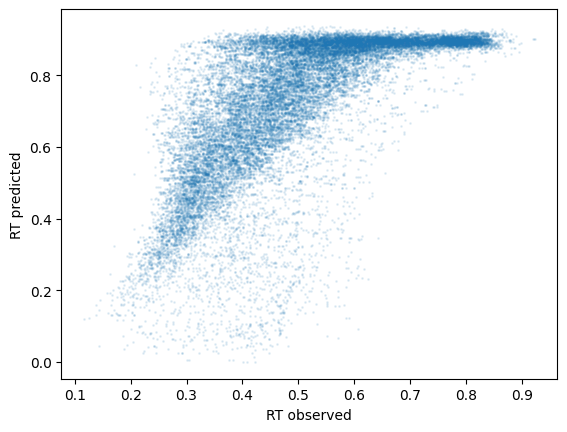

In [11]:

tune_mgr = FinetuneManager(
    device="mps",
    settings=settings)
tune_mgr.nce = 25
tune_mgr.instrument = 'Lumos'
transfer_lib.precursor_df = tune_mgr.predict_rt(transfer_lib.precursor_df)
plt.scatter(transfer_lib.precursor_df['rt_norm'], transfer_lib.precursor_df['rt_norm_pred'], s=1, alpha=0.1)
plt.xlabel('RT observed')
plt.ylabel('RT predicted')

True
2024-04-26 12:04:38> Fine-tuning RT model
2024-04-26 12:04:48> Epoch 0: Lr:0.0 Training loss: 0.07526234518094309, Test loss: 0.04256033611441376
2024-04-26 12:04:57> Epoch 1: Lr:0.0002 Training loss: 0.04150868470555749, Test loss: 0.04256033611441376
2024-04-26 12:05:06> Epoch 2: Lr:0.0004 Training loss: 0.04008666772780747, Test loss: 0.03919054142566493
2024-04-26 12:05:15> Epoch 3: Lr:0.0006000000000000001 Training loss: 0.03604698585795945, Test loss: 0.03541976614073117
2024-04-26 12:05:26> Epoch 4: Lr:0.0008 Training loss: 0.03213042993869247, Test loss: 0.031102395652799885
2024-04-26 12:05:39> Epoch 5: Lr:0.0008 Training loss: 0.02928310038586115, Test loss: 0.029110085838606116
2024-04-26 12:05:50> Epoch 6: Lr:0.0008 Training loss: 0.0275284667531478, Test loss: 0.030186416037547077
2024-04-26 12:06:02> Epoch 7: Lr:0.0008 Training loss: 0.025738675420268857, Test loss: 0.028725033009597934
2024-04-26 12:06:14> Epoch 8: Lr:0.0008 Training loss: 0.02447306991008849, Test 

100%|██████████| 29/29 [00:04<00:00,  7.07it/s]


Text(0, 0.5, 'RT predicted')

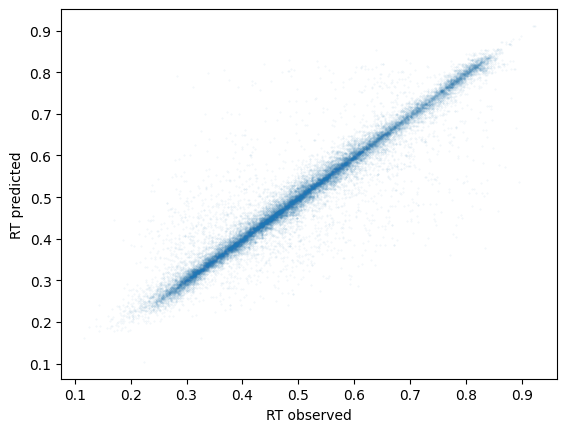

In [5]:
stats = tune_mgr.finetune_rt(transfer_lib.precursor_df)

transfer_lib.precursor_df = tune_mgr.predict_rt(transfer_lib.precursor_df)

plt.scatter(transfer_lib.precursor_df['rt_norm'], transfer_lib.precursor_df['rt_norm_pred'], s=0.1, alpha=0.1)
plt.xlabel('RT observed')
plt.ylabel('RT predicted')


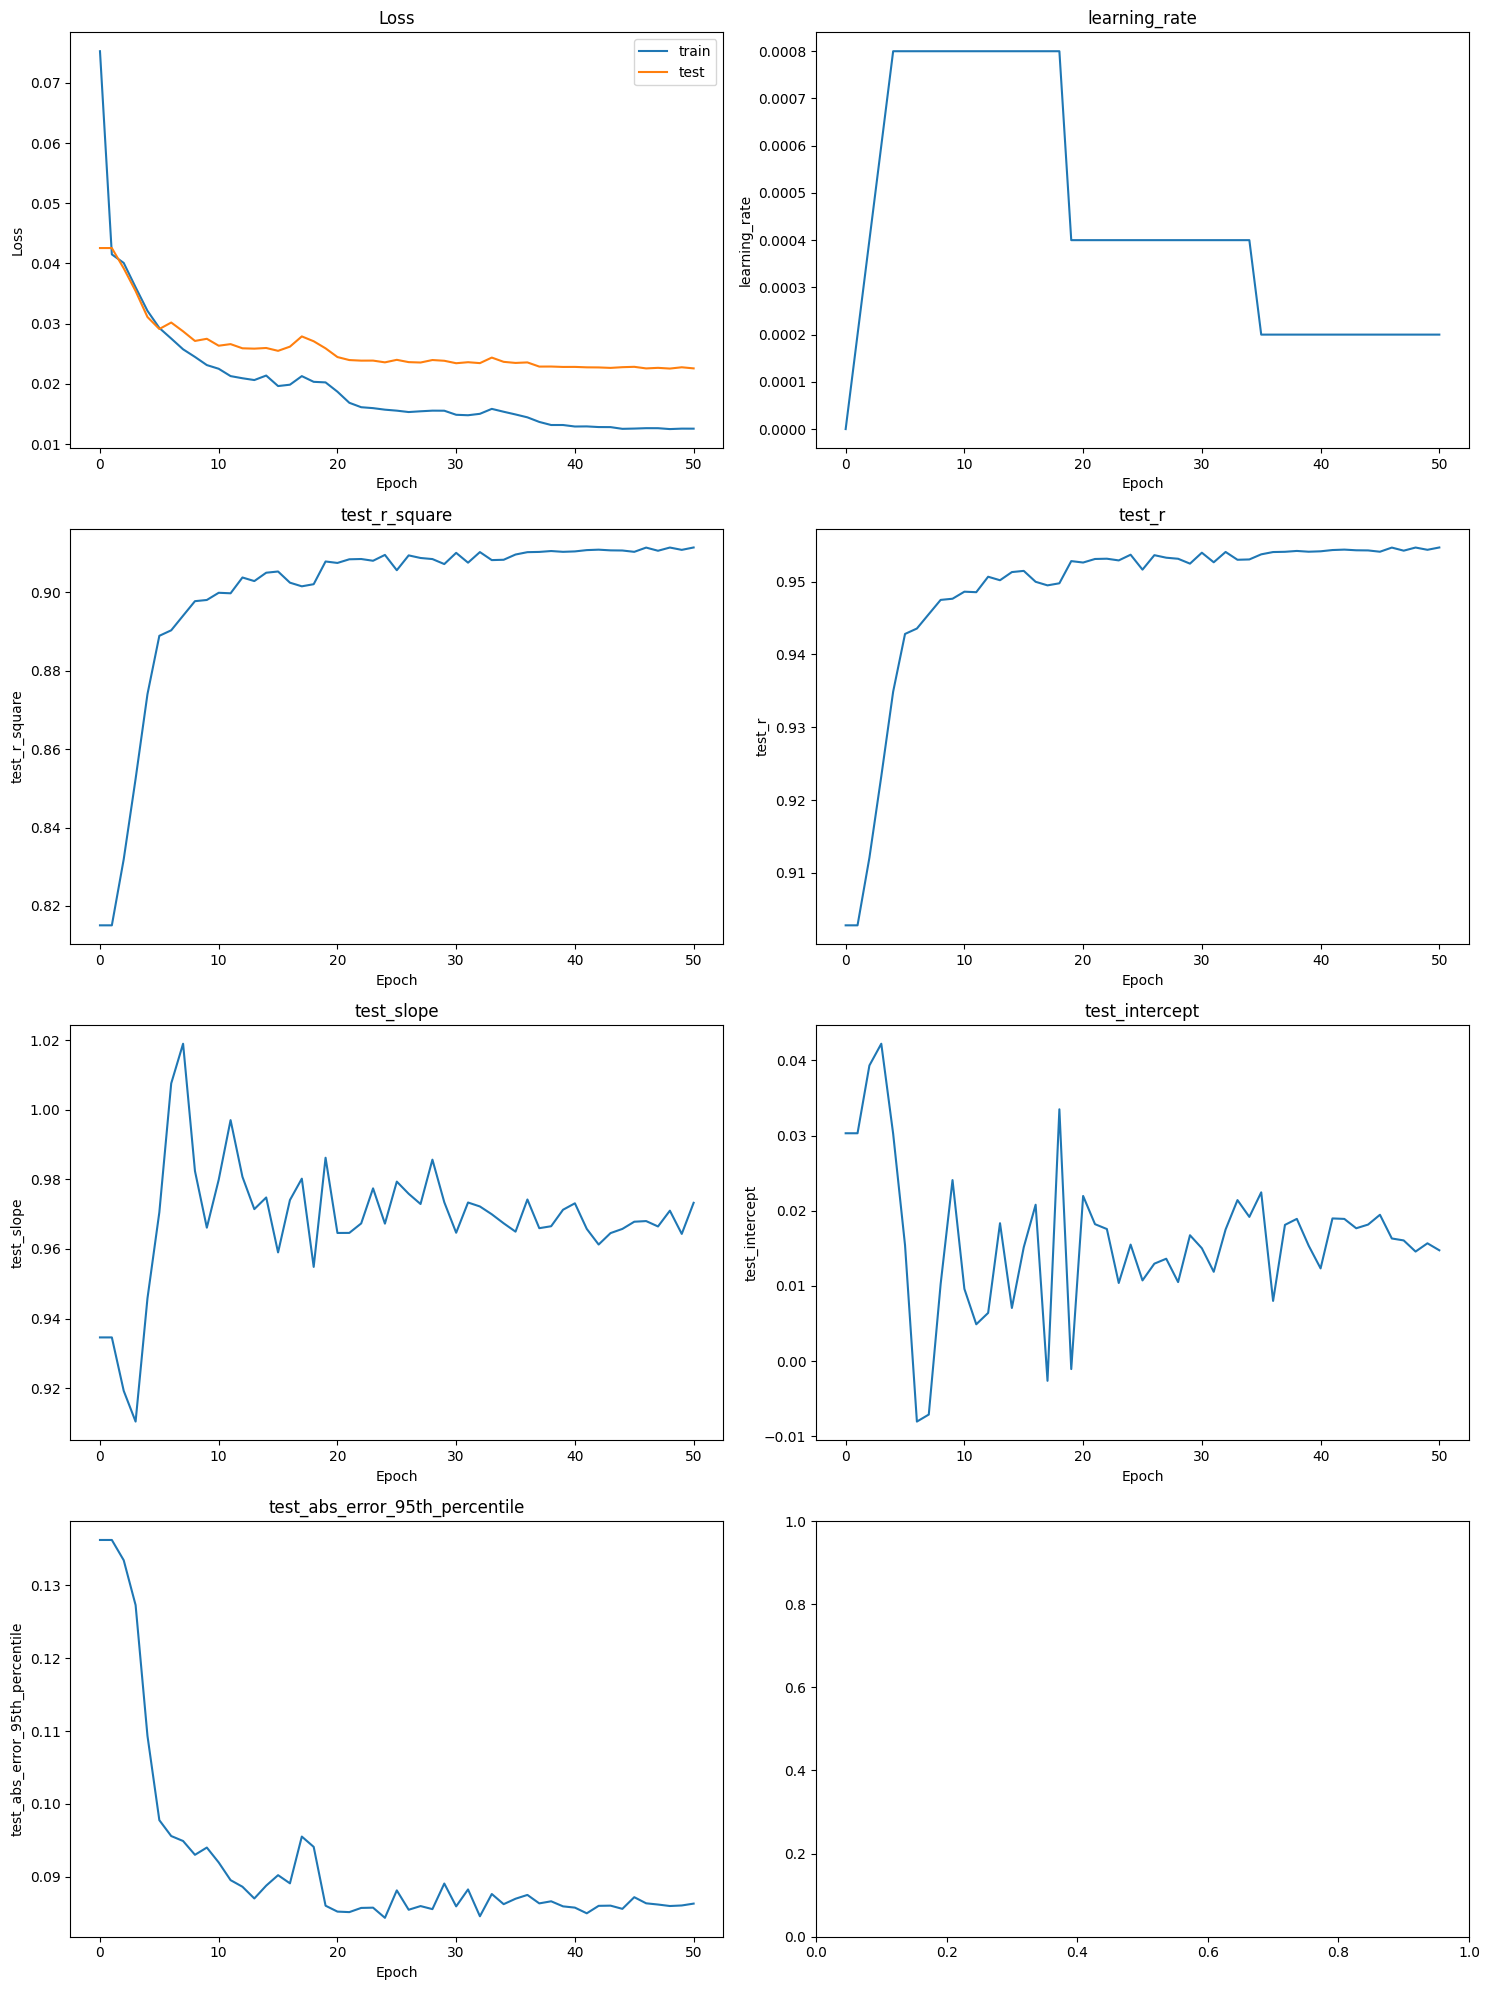

In [6]:

num_plots = len(stats.columns) - 3
fig_col = 2
fig_row = np.ceil(num_plots / fig_col).astype(int) + 1
fig, ax = plt.subplots(fig_row, fig_col, figsize=(15, 5 * fig_row))

x_axis = stats["epoch"]
# Train and test loss
ax[0, 0].plot(x_axis, stats["train_loss"], label="train")
ax[0, 0].plot(x_axis, stats["test_loss"], label="test")
ax[0, 0].set_title("Loss")
ax[0, 0].set_xlabel("Epoch")
ax[0, 0].set_ylabel("Loss")
ax[0, 0].legend()


# Rest of the columns
columns_to_plot = stats.columns.drop(["epoch", "train_loss", "test_loss"])
for i, column_name in enumerate(columns_to_plot):
    row = (i + 1) // fig_col
    col = (i + 1) % fig_col
    ax[row, col].plot(x_axis, stats[column_name])
    ax[row, col].set_title(column_name)
    ax[row, col].set_xlabel("Epoch")
    ax[row, col].set_ylabel(column_name)


plt.tight_layout()
plt.show()

## Charge Fine-tuning

In [12]:

# Testing the charge finetuning on the transfer library
stats = tune_mgr.finetune_charge(psm_df=transfer_lib.precursor_df)

2024-04-26 12:25:08> Fine-tuning Charge model
2024-04-26 12:25:23> Epoch 0: Lr:0.0 Training loss: 0.6088812833031019, Test loss: 2.560538107042268
2024-04-26 12:25:40> Epoch 1: Lr:0.0002 Training loss: 0.7783319135506948, Test loss: 2.560538107042268
2024-04-26 12:25:58> Epoch 2: Lr:0.0004 Training loss: 0.5842120741804441, Test loss: 0.4744156861007678
2024-04-26 12:26:17> Epoch 3: Lr:0.0006000000000000001 Training loss: 0.3939968047042688, Test loss: 0.3562092771977676
2024-04-26 12:26:34> Epoch 4: Lr:0.0008 Training loss: 0.38858429019649826, Test loss: 0.36868499715521297
2024-04-26 12:26:51> Epoch 5: Lr:0.0008 Training loss: 0.4326625699798266, Test loss: 0.6468583069436173
2024-04-26 12:27:09> Epoch 6: Lr:0.0008 Training loss: 0.37469724292556444, Test loss: 0.3286443538409417
2024-04-26 12:27:39> Epoch 7: Lr:0.0008 Training loss: 0.2953255963822206, Test loss: 0.5854926365874882
2024-04-26 12:28:10> Epoch 8: Lr:0.0008 Training loss: 0.30170251404245696, Test loss: 0.335263923477

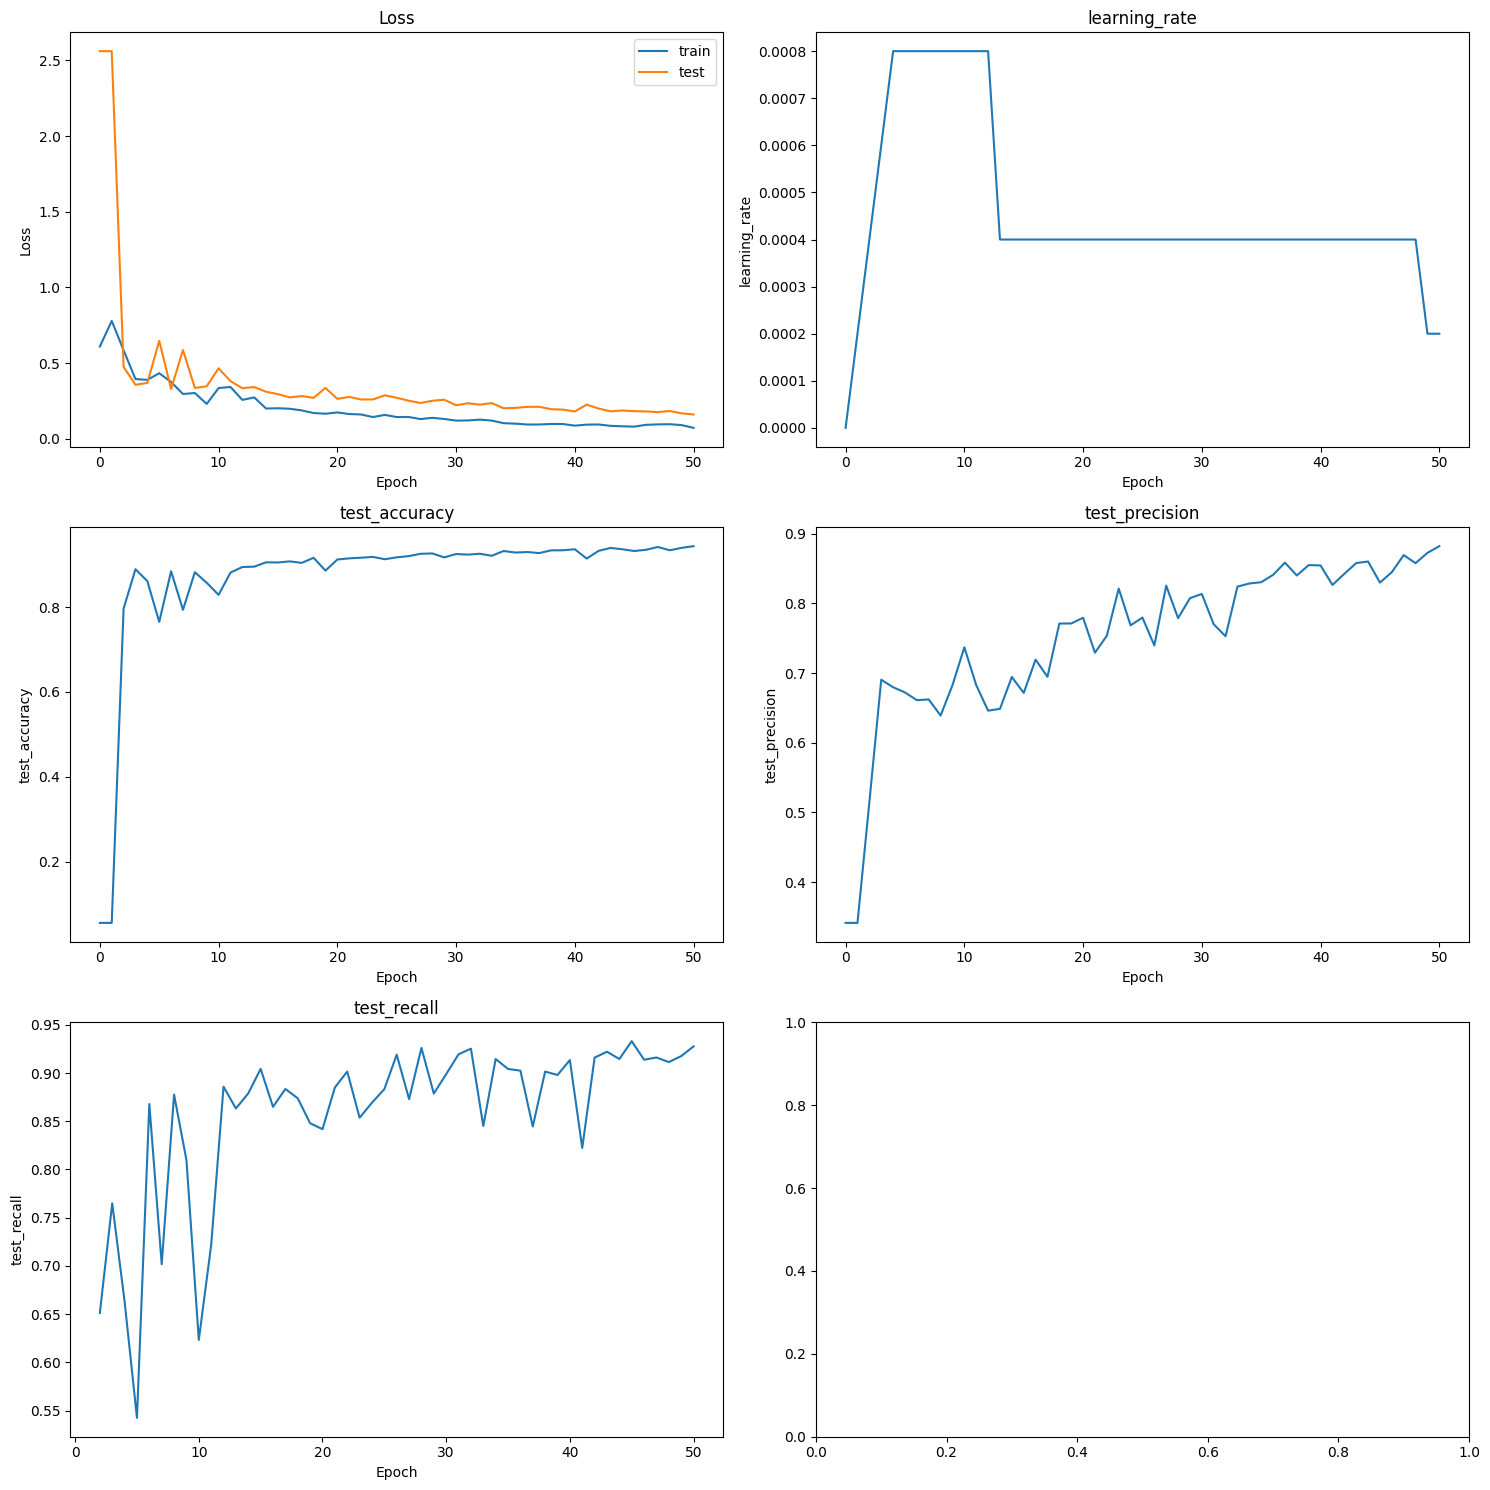

In [13]:

num_plots = len(stats.columns) - 3
fig_col = 2
fig_row = np.ceil(num_plots / fig_col).astype(int) + 1
fig, ax = plt.subplots(fig_row, fig_col, figsize=(15, 5 * fig_row))

x_axis = stats["epoch"]
# Train and test loss
ax[0, 0].plot(x_axis, stats["train_loss"], label="train")
ax[0, 0].plot(x_axis, stats["test_loss"], label="test")
ax[0, 0].set_title("Loss")
ax[0, 0].set_xlabel("Epoch")
ax[0, 0].set_ylabel("Loss")
ax[0, 0].legend()

# Rest of the columns
columns_to_plot = stats.columns.drop(["epoch", "train_loss", "test_loss"])
for i, column_name in enumerate(columns_to_plot):
    row = (i + 1) // fig_col
    col = (i + 1) % fig_col
    ax[row, col].plot(x_axis, stats[column_name])
    ax[row, col].set_title(column_name)
    ax[row, col].set_xlabel("Epoch")
    ax[row, col].set_ylabel(column_name)


plt.tight_layout()
plt.show()

## MS2 Fine-tuning

In [31]:

# Testing the ms2 finetuning on the transfer library
stats = tune_mgr.finetune_ms2(psm_df=transfer_lib.precursor_df,matched_intensity_df=transfer_lib.fragment_intensity_df)

2024-04-19 23:37:03> Fine-tuning MS2 model
2024-04-19 23:37:35> Epoch 0: Lr:0.001 Training loss: 0.017610015122797983, Test loss: 105.32062023997713
2024-04-19 23:38:05> Epoch 1: Lr:0.0 Training loss: 0.01582635704684874, Test loss: 105.32062023997713
2024-04-19 23:38:34> Epoch 2: Lr:0.0002 Training loss: 0.015057623097351912, Test loss: 105.32106991047291
2024-04-19 23:39:04> Epoch 3: Lr:0.0004 Training loss: 0.013058155341523475, Test loss: 105.32062204157569
2024-04-19 23:39:33> Epoch 4: Lr:0.0006000000000000001 Training loss: 0.012706901653316515, Test loss: 105.32025263618122
2024-04-19 23:40:03> Epoch 5: Lr:0.0008 Training loss: 0.012793854184063345, Test loss: 105.31916430808276
2024-04-19 23:40:33> Epoch 6: Lr:0.0008 Training loss: 0.012641142427535921, Test loss: 105.32069829513242
Training stopped at epoch 6
2024-04-19 23:40:33> Fine tuning finished at epoch: 6 
train_loss: 0.012641142427535921 
learning_rate: 0.0008 
test_loss: 105.32069829513242 
test_pcc_mean: 0.0683985278

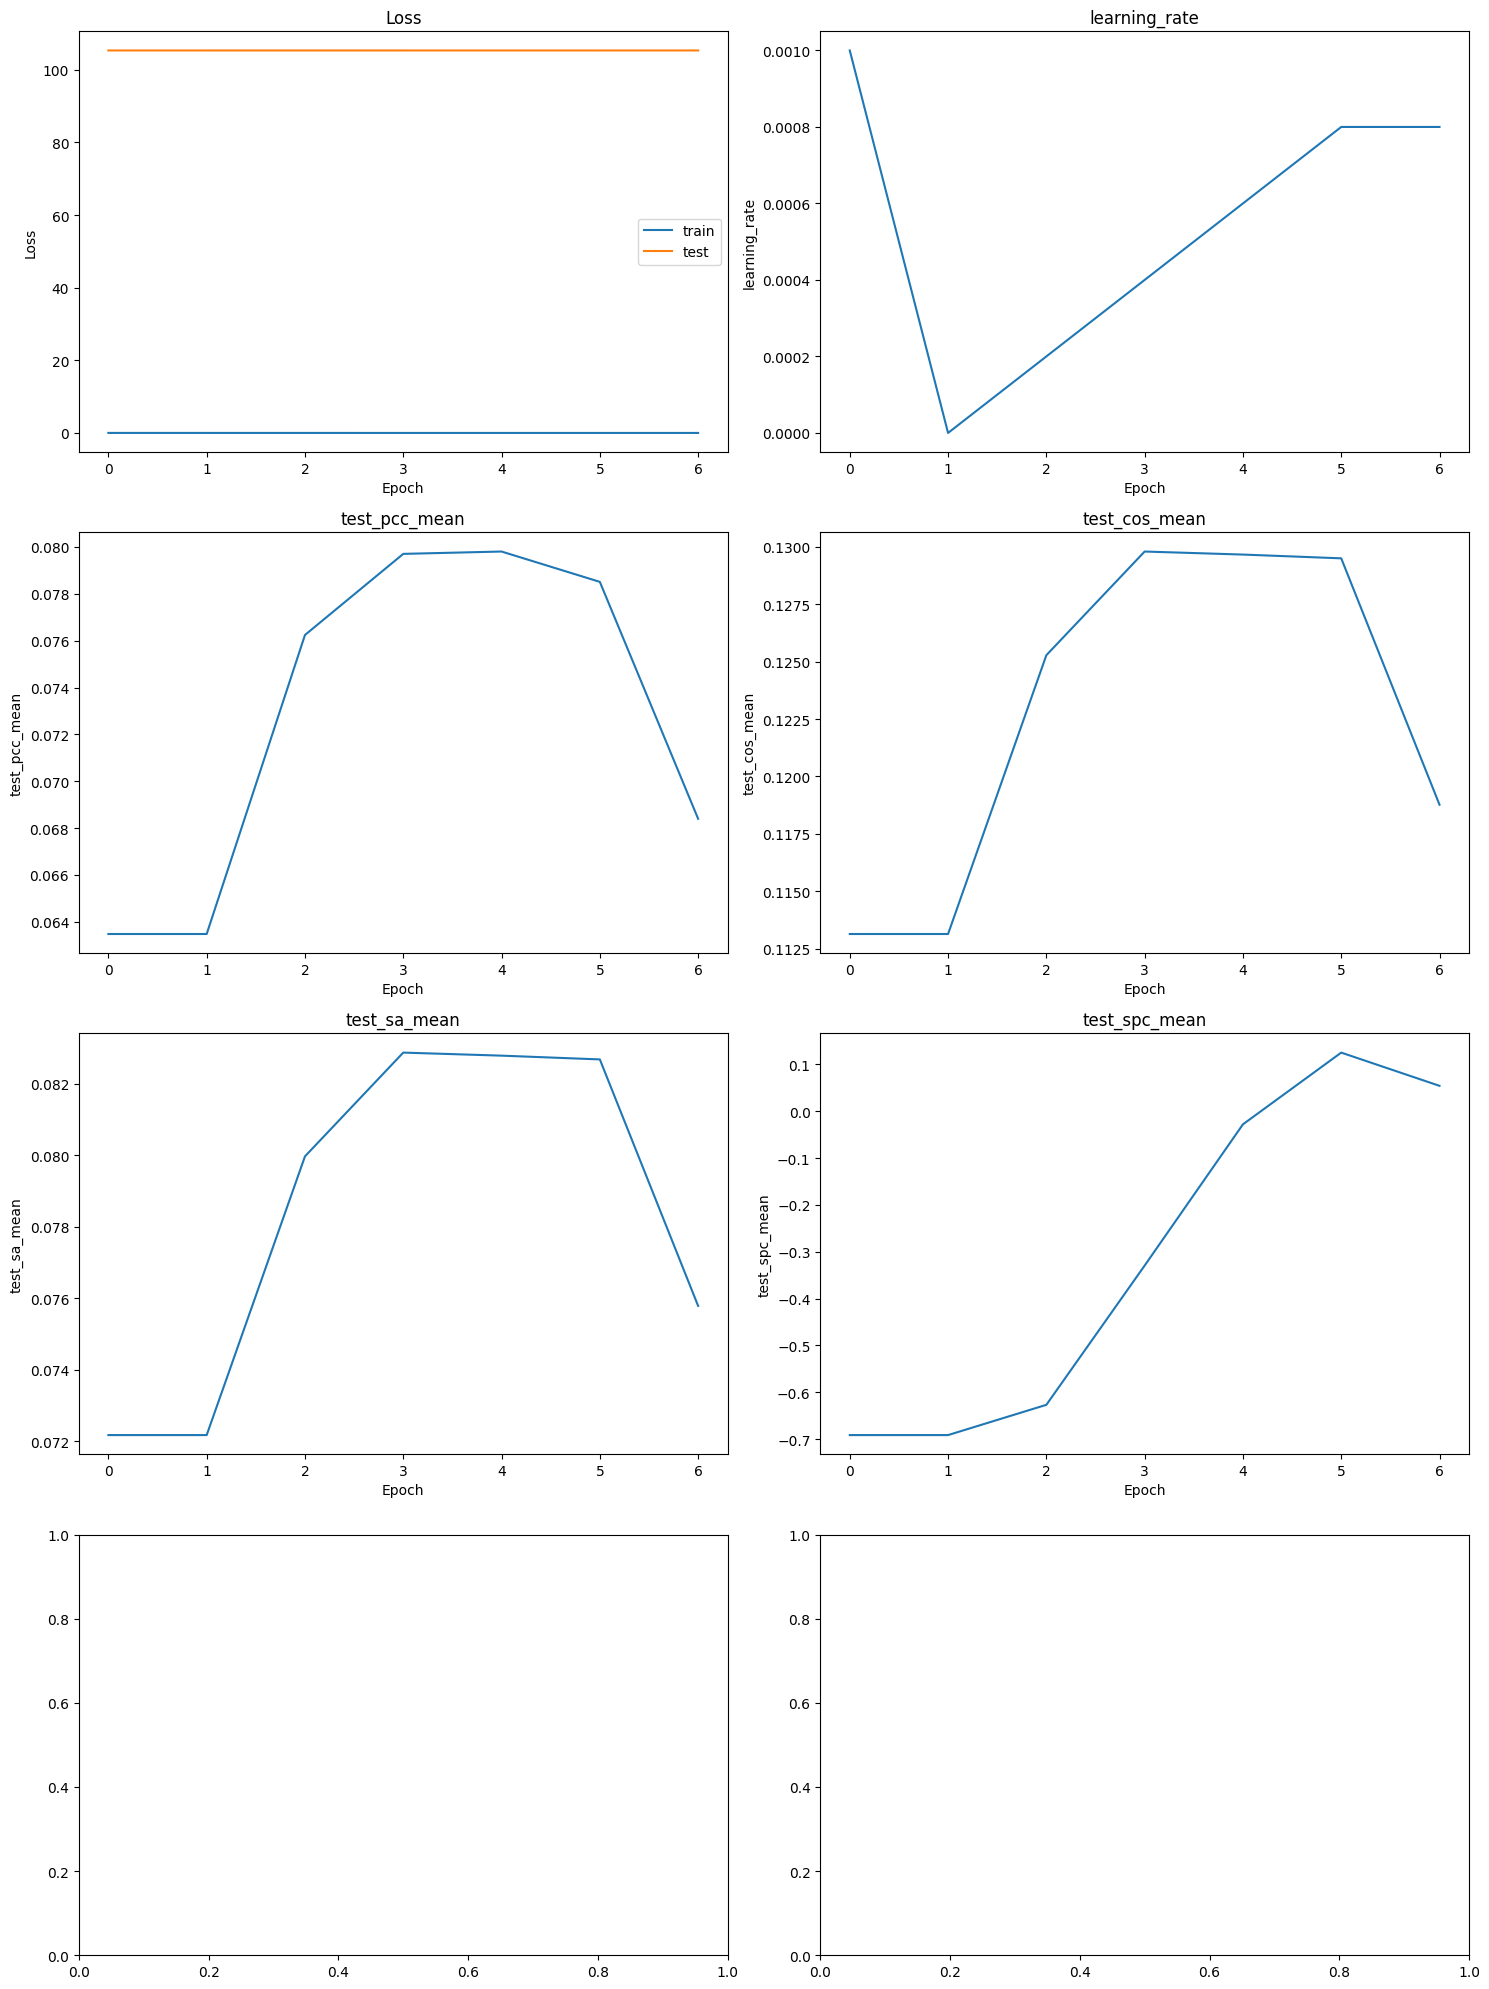

In [32]:

num_plots = len(stats.columns) - 3
fig_col = 2
fig_row = np.ceil(num_plots / fig_col).astype(int) + 1
fig, ax = plt.subplots(fig_row, fig_col, figsize=(15, 5 * fig_row))

x_axis = stats["epoch"]
# Train and test loss
ax[0, 0].plot(x_axis, stats["train_loss"], label="train")
ax[0, 0].plot(x_axis, stats["test_loss"], label="test")
ax[0, 0].set_title("Loss")
ax[0, 0].set_xlabel("Epoch")
ax[0, 0].set_ylabel("Loss")
ax[0, 0].legend()


# Rest of the columns
columns_to_plot = stats.columns.drop(["epoch", "train_loss", "test_loss"])
for i, column_name in enumerate(columns_to_plot):
    row = (i + 1) // fig_col
    col = (i + 1) % fig_col
    ax[row, col].plot(x_axis, stats[column_name])
    ax[row, col].set_title(column_name)
    ax[row, col].set_xlabel("Epoch")
    ax[row, col].set_ylabel(column_name)


plt.tight_layout()
plt.show()